# Linear Regression using HNP

from https://docs.zama.ai/hnp/user/practical-examples/linear-regression.html

In [2]:
import hnumpy as hnp
import numpy as np

In [3]:
# Dataset

x = np.array([[130], [110], [100], [145], [160], [185], [200], [80], [50]])
y = np.array([325, 295, 268, 400, 420, 500, 520, 220, 120])

## Model

In [4]:
class Model:
    θ = None
    c = None

    def fit(self, x, y):
        A = np.ones((x.shape[0], x.shape[1] + 1), dtype=np.float32)
        A[:, 1:] = x

        regularization_contribution = np.identity(x.shape[1] + 1, dtype=np.float32)
        regularization_contribution[0][0] = 0

        parameters = np.linalg.pinv(A.T @ A + regularization_contribution) @ A.T @ y

        self.c = parameters[0]
        self.θ = parameters[1:].reshape(-1, 1)

        return self

    def evaluate(self, x):
        return x @ self.θ + self.c

## Training

In [5]:
model = Model().fit(x, y)

## Clear prediction

In [6]:
inputs = np.linspace(40, 210, 100).reshape(-1, 1)
predictions = model.evaluate(inputs)

## HNP Compilation

In [7]:
homomorphic_model = hnp.compile_fhe(
    model.evaluate,
    {"x": hnp.encrypted_ndarray(bounds=(35, 215), shape=inputs.shape)},
    config=hnp.config.CompilationConfig(parameter_optimizer="handselected", bits_of_security=80),
)

2022-01-05 09:09:51.539 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling evaluate into an FHE function
2022-01-05 09:09:51.541 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-05 09:09:51.542 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-05 09:09:51.545 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `handselected`
2022-01-05 09:09:51.557 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-05 09:09:51.558 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-05 09:09:51.560 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller


## Homomorphic Evaluation

In [9]:
context = homomorphic_model.create_context()
keys = context.keygen()
homomorphic_predictions = homomorphic_model.encrypt_and_run(keys, inputs)

2022-01-05 09:10:15.749 | INFO     | hnumpy.client:keygen:28 - Creating 0 keyswitching key(s) and 1 bootstrapping key(s). This should take approximately 30 seconds (0.5 minutes)
2022-01-05 09:18:02.010 | DEBUG    | hnumpy.client:keygen:42 - Key creation time took 466.25937936399987 seconds


## Comparison

In [26]:
precision = homomorphic_model.expected_precision()
print(f"expected precision: {precision[0]:.3f}")

error = np.abs(homomorphic_predictions - predictions)
assert np.percentile(error, 99) < precision

print(f"mean error: {np.mean(error):.3f}")

expected precision: 35.907
mean error: 2.128


## Viz

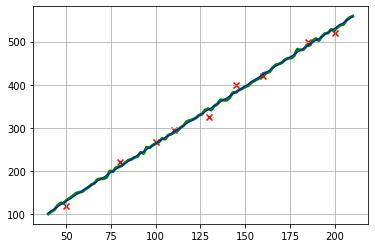

In [36]:
import matplotlib.pyplot as plt

plt.scatter(x, y, marker='x', color="red")
plt.plot(inputs.flatten(), homomorphic_predictions, color="green", linewidth=3)
plt.plot(inputs.flatten(), predictions, color="blue", linewidth=1)
plt.grid()

plt.show()
